# Detection of Melanoma

## Background:

This is an unguided project from Udacity's Deep Learning Nanodegree.
Creating the Neural Network was an individual job, but the code that received results from the created CNN and plotting confusion matrices were given as pre-made files already.


The data was pulled from the 2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection
See: https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a


This convolutional neural network is made using transfer learning from the Inception v3 model imported from pytorch. The decision to use Inception v3 was inspired by the previous work done by Stanford University's Artificial Intelligence Lab.

See: https://cs.stanford.edu/people/esteva/nature/

## Import Data

In [9]:
import numpy as np
import os
from torchvision import datasets, models, transforms
import torch
from PIL import ImageFile

train_transforms = transforms.Compose([transforms.RandomResizedCrop(299, scale=(0.7,1.0)),
                                       transforms.RandomHorizontalFlip(0.5),
                                       transforms.RandomVerticalFlip(0.5),
                                       transforms.RandomRotation(30),
                                       transforms.ToTensor(),
                                      ])

valid_train_transforms = transforms.Compose([transforms.RandomResizedCrop(299, scale=(0.8,1.0)),
                                            transforms.ToTensor(),
                                            ])

train_dir = './data/train/'
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)

valid_dir = './data/valid/'
valid_data = datasets.ImageFolder(valid_dir, transform=valid_train_transforms)

test_dir = './data/test/'
test_data = datasets.ImageFolder(test_dir, transform=valid_train_transforms)

print("There are {} total train images, {} total validation images, and {} total test images".format(len(train_data),
                                                                                                     len(valid_data),
                                                                                                     len(test_data)))

There are 2000 total train images, 150 total validation images, and 600 total test images


In [10]:
### DATA LOADERS

batch_size = 20
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         num_workers=num_workers, shuffle=True)


loaders = {'train': train_loader,
           'valid': valid_loader,
           'test': test_loader}

## Take a look at some sample data

torch.Size([3, 299, 299])


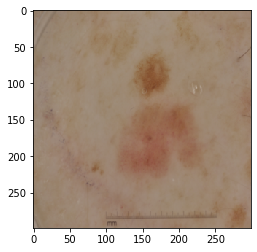

In [11]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = test_data[2][0]

plt.imshow(img.permute(1, 2, 0))
print(img.shape)

# From here, we see the image has 3 channels (RGB) and is sized at 299 by 299.
# Inception v3 requires input of 299 x 299.

## Model architecture

In [12]:
import torchvision.models as models
import torch.nn as nn

inception = models.inception_v3(aux_logits=False)

print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

)


In [13]:
# Based on the above, we can see that the final fully connected layer has an output of 1000.
# In this classification, we have 3 outputs.
# The outcome could be: melanoma (cancerous), nevus (non-cancerous), or seborrheic keratosis (non-cancerous)

classes = ['melanoma', 'nevus', 'seborrheic keratosis']

In [14]:
# Freeze all weights
for param in inception.parameters():
    param.requires_grad = False
    
# Instantiate a new final layer
inception.fc = nn.Linear(inception.fc.in_features, len(classes))

# Check if cuda is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    inception = inception.cuda()
    
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

)


In [15]:
import torch.optim as optim
# Loss and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(inception.fc.parameters(), lr=0.001, momentum=0.8)

In [16]:
### TRAIN THE MODEL ###
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        
        # initialize training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ### TRAIN ###
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU if there is
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + (1 / (batch_idx+1)) * (loss.data - train_loss)
            
        ### VALIDATE ###
        model.eval()

        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU if there is
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + (1 / (batch_idx+1)) * (loss.data - valid_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

In [17]:
#inception = train(30, loaders, inception, optimizer, criterion, use_cuda, 'inception.pt')

In [18]:
inception.load_state_dict(torch.load('inception.pt'))

<All keys matched successfully>

In [19]:
inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [20]:
## TEST THE MODEL

def test(loaders, model, criterion, use_cuda):
    
    # variables to monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        # move to gpu if there is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        # forward pass
        output = model(data)
        
        # loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, inception, criterion, use_cuda)

Test Loss: 0.900021


Test Accuracy: 65% (393/600)


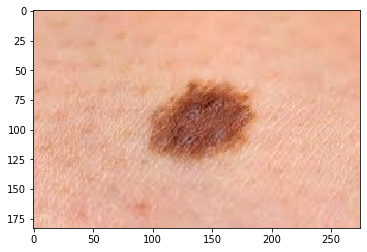

nevus


In [37]:
### Create a function that takes in an image and
### outputs a prediction

from PIL import Image
from torch.autograd import Variable

def prediction(img_path):
    # show the image
    
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    image_transform = transforms.Compose([transforms.Resize(299),
                                         transforms.ToTensor()])
    
    img = Image.open(img_path)
    img = image_transform(img).float()
    img = Variable(img, requires_grad=True)
    img = img.unsqueeze(0)
    
    
    predict = inception(img)
    
    print(classes[torch.argmax(predict)])
    
prediction('./images/melanoma1.jfif')
